# Quickstart: 様々なオフ方策推定量によるオフ方策評価 (離散空間)

このノートブックではReal-Time Bidding (RTB)人工データと様々なOPE推定量 (モデルベース，重点サンプリング，周辺化重点サンプリング，double reinforcement learningなど) を紹介します．

特に、以下の2つの順番で解説していきます: 
1. セットアップ, 人工データの生成とオフライン強化学習
2. 様々なオフ方策推定量によるオフ方策評価

このライブラリは，オンラインとオフラインの方策学習およびモデルベースのオフ方策評価の一部で [d3rlpy](https://github.com/takuseno/d3rlpy)のアルゴリズムを利用しています．
また、実装のワークフローは[Open Bandit Pipeline](https://github.com/st-tech/zr-obp)を参考にしています．

In [1]:
# SCOPE-RL モジュールのインポート
import scope_rl
from rtbgym import RTBEnv, CustomizedRTBEnv
from scope_rl.dataset import SyntheticDataset
from scope_rl.policy import OnlineHead
from scope_rl.policy import EpsilonGreedyHead
from scope_rl.policy import SoftmaxHead
from scope_rl.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)

# d3rlpy アルゴリズムのインポート
from d3rlpy.algos import DiscreteRandomPolicy as RandomPolicy
from d3rlpy.preprocessing import MinMaxObservationScaler

# その他のライブラリのインポート
import gym
import torch

In [2]:
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
# バージョン
print(scope_rl.__version__)

0.2.1


In [4]:
# random stateの設定
random_state = 12345

In [5]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [6]:
# logディレクトリ
from pathlib import Path
Path("logs/").mkdir(exist_ok=True)

In [7]:
# warnings
import warnings
warnings.simplefilter('ignore')

## 1. セットアップ，人工データ生成，オフライン強化学習
まず初めに，今回用いるRTB環境を紹介します．

#### 強化学習でのRTB環境のセットアップ
RTBにおいて強化学習エージェントの目的は，予算制約が与えられもとで，1エピソード内のKPI(クリックやコンバージョン)を最大化することです. KPIを最大にするために，エージェントは入札価格関数パラメータ $\alpha$ を選択します．
入札価格関数パラメータ $\alpha$ を利用することで下の入札価格を決定します．\
$bid_{t，i} = \alpha \cdot r^{\ast}$，
ここで$r^{\ast}$はKPIsの予測または期待値を表します.

この問題を制約付きマルコフ決定過程(CMDP)として定式化します.

- `タイムステップ`: 1エピソード(一日，1週間)に含まれるタイムステップ(24時間， 数日など).
- `状態`: それぞれのタイムステップで，環境からフィードバックが返ってきます.
  - タイムステップ
  - 残予算
  - 一つ前のタイムステップでのインプレッション単位の特徴(予算消費率，1インプレッションあたりのコスト，オークション落札率，報酬)
  - 一つ前のタイムステップでの入札関数パラメータ(強化学習エージェントが選ぶ行動) 
- `行動`: エージェントはKPIを最大化するために入札価格パラメータ$\alpha$を選択します.
- `報酬`: 1タイムステップあたりの得られたトータルのクリックまたはコンバージョンの数.
- `制約`: あらかじめ決められた1エピソードあたりの超えてはいけない予算．

より詳細に環境の引数を確認したい場合は，次のノートブックを参照してください． [examples/quickstart_ja/rtb/rtb_synthetic_customize_env_ja.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart_ja/rtb/rtb_synthetic_customize_env_ja.ipynb).

In [8]:
# SCOPE-RLで実装されている離散行動空間に対する標準的な環境
env = gym.make("RTBEnv-discrete-v0")

#### 人工データの生成
次にデータ収集方策$\pi_0$からデータを集めます：
$$\mathcal{D}_0 := \{ \{ s_t, a_t, s_{t+1}, r_t \}_{t=1}^T \}_{i=1}^n \sim \prod_{i=1}^n d_{s_0}(s_0) \prod_{t=1}^T \pi_0(a_t | s_t) p(s_{t+1} | s_t, a_t) p(r_t | s_t, a_t),$$

ここで $s_t \in \mathcal{S}$ は時刻$t$で観測された状態，$a_t$ はデータ収集方策 $\pi_0$によって選択された行動，$r_t$は状態と行動に応じて観測された報酬を表します．

`SyntheticDataset` は以下の引数を持っています:
- `env`: 前のセクションで紹介したRTB環境を定義.
- `max_episode_steps`: エージェントの行動インデックスと実際の"離散"行動のマッピング関数.
- `state_keys`: 状態変数の名前.
- `max_episode_steps`: 一つのエピソードにおける連続意思決定の数（上限）.
- `info_keys`: キーと情報のタイプを含んだ辞書.

より詳細にデータ収集と可視化について知りたい場合は，以下を参照してください．[examples/quickstart_ja/rtb/rtb_synthetic_data_collection_ja.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart_ja/rtb/rtb_synthetic_data_collection_ja.ipynb).

In [9]:
# データ収集方策
from d3rlpy.algos import DoubleDQNConfig
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.dataset import create_fifo_replay_buffer
from d3rlpy.algos import LinearDecayEpsilonGreedy

# モデル
ddqn = DoubleDQNConfig(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    target_update_interval=100,
).create(device=device)

# 再生バッファの設定
buffer = create_fifo_replay_buffer(
    limit=10000,
    env=env,
)

# 探索
explorer = LinearDecayEpsilonGreedy(
    start_epsilon=1.0,
    end_epsilon=0.1,
    duration=1000,
)

In [ ]:
# 学習の開始
# 事前学習したモデルを利用する場合はスキップ
ddqn.fit_online(
    env,
    buffer,
    explorer=explorer,
    eval_env=env,
    n_steps=100000,
    n_steps_per_epoch=1000,
    update_start_step=1000,
)

In [ ]:
# モデルの保存
ddqn.save_model("d3rlpy_logs/ddqn.pt")

In [10]:
# モデルのリロード
ddqn.build_with_env(env)
ddqn.load_model("d3rlpy_logs/ddqn.pt")

In [11]:
behavior_policy = EpsilonGreedyHead(
    ddqn, 
    n_actions=env.action_space.n,
    epsilon=0.3,
    name="ddqn_epsilon_0.3",
    random_state=random_state,
)

In [12]:
# データセットクラスの初期化
dataset = SyntheticDataset(
    env=env,
    action_meaning=env.action_meaning,
    state_keys=env.obs_keys,
    max_episode_steps=env.step_per_episode,
    info_keys={
        "search_volume": int,
        "impression": int,
        "click": int,
        "conversion": int,
        "average_bid_price": float,
    },
)

In [ ]:
# データ収集方策によってログデータを集める
# ログデータがある存在する場合はスキップ
train_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy,
    n_trajectories=10000, 
    obtain_info=True,
    random_state=random_state,
)
test_logged_dataset = dataset.obtain_episodes(
    behavior_policies=behavior_policy,
    n_trajectories=10000, 
    obtain_info=True,
    random_state=random_state,
)

In [61]:
with open("logs/train_dataset_discrete_ddpn.pkl", "wb") as f:
    pickle.dump(train_logged_dataset, f)
with open("logs/test_dataset_discrete_ddpn.pkl", "wb") as f:
    pickle.dump(test_logged_dataset, f)

In [13]:
with open("logs/train_dataset_discrete_ddqn.pkl", "rb") as f:
    train_logged_dataset = pickle.load(f)
with open("logs/test_dataset_discrete_ddqn.pkl", "rb") as f:
    test_logged_dataset = pickle.load(f)

#### オフライン強化学習
この章では実環境と相互作用せずに，ログデータのみから新しい方策を学習する方法を紹介します．
オフライン強化学習のアルゴリズムは [d3rlpy](https://github.com/takuseno/d3rlpy)に実装されているものを利用します．

オフライン強化学習の手順について詳細に知りたい方は，以下を参照してください[examples/quickstart_ja/rtb/rtb_synthetic_discrete_basic_ja.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart_ja/rtb/rtb_synthetic_discrete_basic_ja.ipynb).

In [14]:
# d3rlpyのモジュールのインポート
from d3rlpy.dataset import MDPDataset
from d3rlpy.algos import DiscreteCQLConfig as CQLConfig
# d3rlpy用にオフラインデータセットを変形
offlinerl_dataset = MDPDataset(
    observations=train_logged_dataset["state"],
    actions=train_logged_dataset["action"],
    rewards=train_logged_dataset["reward"],
    terminals=train_logged_dataset["done"],
)

In [15]:
# Conservative Q-Learning 方策を利用
cql = CQLConfig(
    encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
).create(device=device)

In [ ]:
cql.fit(
    offlinerl_dataset,
    n_steps=10000,
)

In [23]:
# モデルの保存
cql.save_model("d3rlpy_logs/cql_discrete.pt")

In [16]:
# モデルのリロード
cql.build_with_env(env)
cql.load_model("d3rlpy_logs/cql_discrete.pt")

## 2. 様々なオフ方策推定量によるオフ方策評価
評価対象の方策が学習できたところで，方策の性能指標となる様々な統計量を，オフ方策評価を用いて（オフラインで）推定していきます．

#### 推定目標
ここでは，方策の期待性能 (*方策価値*) を推定します．

$$ V(\pi) := \mathbb{E}\left[\sum_{t=1}^T \gamma^{t-1} r_t \mid \pi \right] $$

In [17]:
# SCOPE-RLからのopeモジュールのインポート
from scope_rl.ope import CreateOPEInput
from scope_rl.ope import OffPolicyEvaluation as OPE
# 標準的な推定量
from scope_rl.ope.discrete import DirectMethod as DM
from scope_rl.ope.discrete import TrajectoryWiseImportanceSampling as TIS
from scope_rl.ope.discrete import PerDecisionImportanceSampling as PDIS
from scope_rl.ope.discrete import DoublyRobust as DR
# self normalized推定量
from scope_rl.ope.discrete import SelfNormalizedTIS as SNTIS
from scope_rl.ope.discrete import SelfNormalizedPDIS as SNPDIS
from scope_rl.ope.discrete import SelfNormalizedDR as SNDR
# marginal推定量
from scope_rl.ope.discrete import StateActionMarginalIS as SAMIS
from scope_rl.ope.discrete import StateActionMarginalDR as SAMDR
from scope_rl.ope.discrete import StateMarginalIS as SMIS
from scope_rl.ope.discrete import StateMarginalDR as SMDR
from scope_rl.ope.discrete import StateActionMarginalSNIS as SAMSNIS
from scope_rl.ope.discrete import StateActionMarginalSNDR as SAMSNDR
from scope_rl.ope.discrete import StateMarginalSNIS as SMSNIS
from scope_rl.ope.discrete import StateMarginalSNDR as SMSNDR
# double reinforcement learning推定量
from scope_rl.ope.discrete import DoubleReinforcementLearning as DRL

In [18]:
from d3rlpy.algos import DiscreteRandomPolicyConfig
random = DiscreteRandomPolicyConfig().create(device=device)
random.build_with_env(env)

In [19]:
# 評価方策を定義
cql_ = EpsilonGreedyHead(base_policy=cql, n_actions=env.action_space.n, name="cql", epsilon=0.0, random_state=random_state)
ddqn_ = EpsilonGreedyHead(base_policy=ddqn, n_actions=env.action_space.n, name="ddqn", epsilon=0.0, random_state=random_state)
random_ = EpsilonGreedyHead(base_policy=random, n_actions=env.action_space.n, name="random", epsilon=1.0, random_state=random_state)
evaluation_policies = [cql_, ddqn_, random_]

In [20]:
# まずOPEのインプットを準備
prep = CreateOPEInput(
    env=env,
    model_args={
        "fqe": {
            "encoder_factory": VectorEncoderFactory(hidden_units=[30, 30]),
            "q_func_factory": MeanQFunctionFactory(),
            "learning_rate": 1e-4,
        },
    },
    state_scaler=MinMaxObservationScaler(
        minimum=test_logged_dataset["state"].min(axis=0),
        maximum=test_logged_dataset["state"].max(axis=0),
    ),
    gamma=0.95,
)

In [ ]:
# 計算に時間がかかります
input_dict = prep.obtain_whole_inputs(
    logged_dataset=test_logged_dataset,
    evaluation_policies=evaluation_policies,
    require_value_prediction=True,
    require_weight_prediction=True,
    n_trajectories_on_policy_evaluation=100,
    random_state=random_state,
)

In [22]:
with open("logs/ope_input_dict_discrete_zoo.pkl", "wb") as f:
    pickle.dump(input_dict, f)

In [23]:
with open("logs/ope_input_dict_discrete_zoo.pkl", "rb") as f:
    input_dict = pickle.load(f)

In [24]:
basic_estimators = [DM(), TIS(), PDIS(), DR(), SNTIS(), SNPDIS(), SNDR()]
state_marginal_estimators = [SMIS(), SMDR(), SMSNIS(), SMSNDR()]
state_action_marginal_estimators = [SAMIS(), SAMDR(), SAMSNIS(), SAMSNDR()]
drl_estimators = [DRL()]
all_estimators = basic_estimators + state_marginal_estimators + state_action_marginal_estimators + drl_estimators

In [25]:
basic_estimators_name = ["dm", "tis", "pdis", "dr", "sntis", "snpdis", "sndr"]
state_marginal_estimators_name = ["sm_is", "sm_dr", "sm_snis", "sm_sndr"]
state_action_marginal_estimators_name = ["sam_is", "sam_dr", "sam_snis", "sam_sndr"]
drl_estimators_name = ["drl"]

In [26]:
ope = OPE(
    logged_dataset=test_logged_dataset,
    ope_estimators=all_estimators,
)

In [27]:
# opeによる性能評価
policy_value_df_dict, policy_value_interval_df_dict = ope.summarize_off_policy_estimates(
    input_dict, 
    random_state=random_state,
)
# 性能推定結果（辞書）
policy_value_df_dict

{'cql':            policy_value  relative_policy_value
 on_policy     13.670803               1.000000
 dm            19.692582               1.440485
 tis            0.013220               0.000967
 pdis          10.308965               0.754086
 dr            13.913196               1.017731
 sntis         14.604998               1.068335
 snpdis        12.109122               0.885765
 sndr          13.480904               0.986109
 sm_is          1.424221               0.104180
 sm_dr         19.258980               1.408767
 sm_snis       10.870918               0.795192
 sm_sndr       10.705989               0.783128
 sam_is         7.883300               0.576652
 sam_dr        18.898415               1.382392
 sam_snis      15.068570               1.102245
 sam_sndr      18.351390               1.342378
 drl           16.713641               1.222579,
 'ddqn':            policy_value  relative_policy_value
 on_policy     14.049627               1.000000
 dm            12.252217

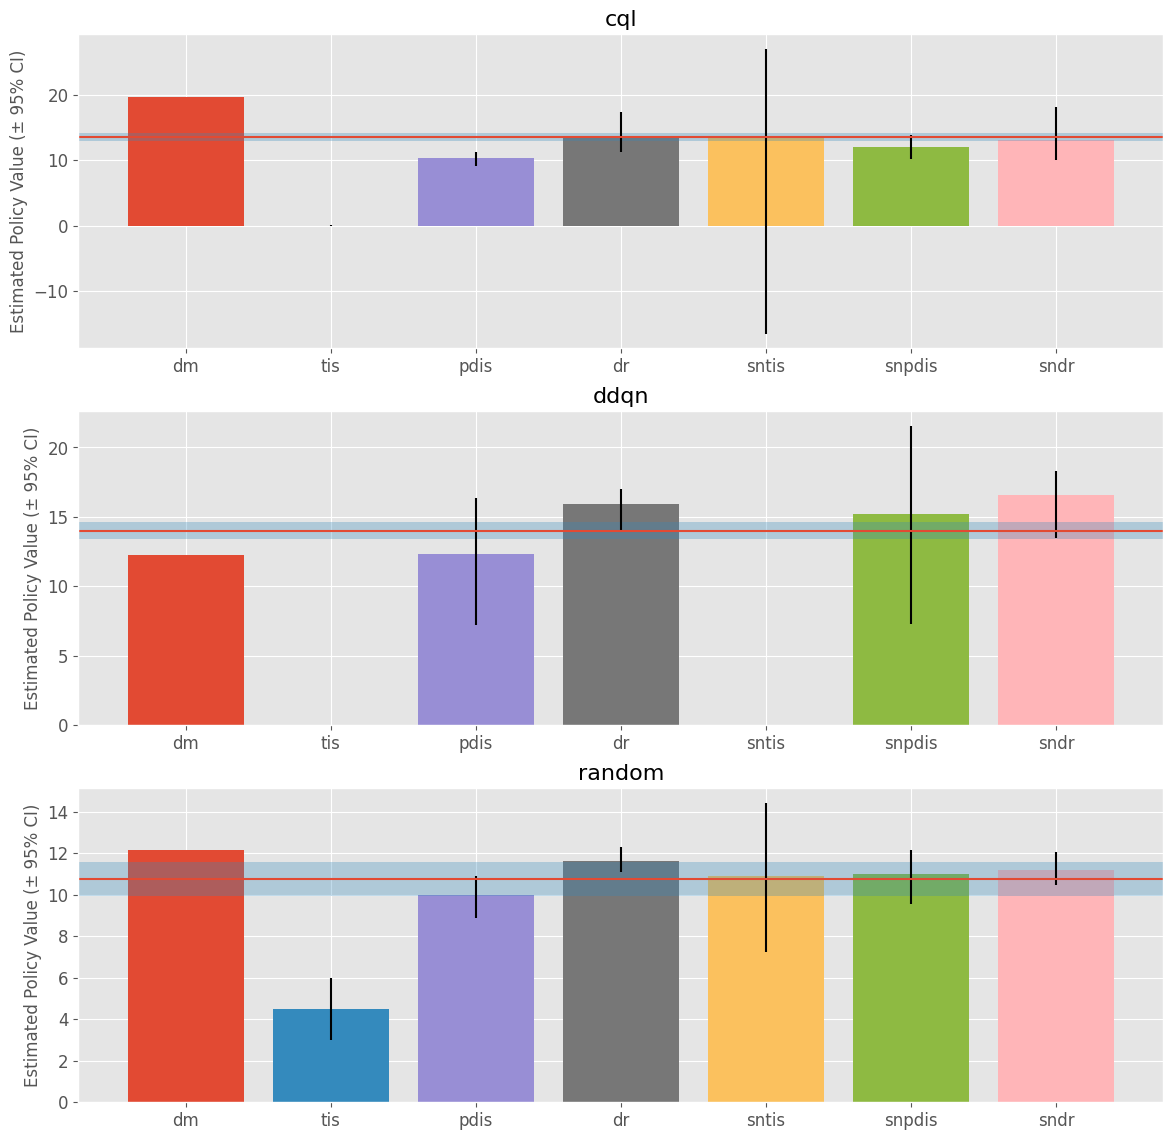

In [28]:
# opeの結果の比較・可視化
ope.visualize_off_policy_estimates(
    input_dict, 
    compared_estimators=basic_estimators_name,
    random_state=random_state, 
    sharey=False,
)
# データ収集方策に対する相対方策価値
# ope.visualize_off_policy_estimates(input_dict, random_state=random_state, is_relative=True, sharey=False)

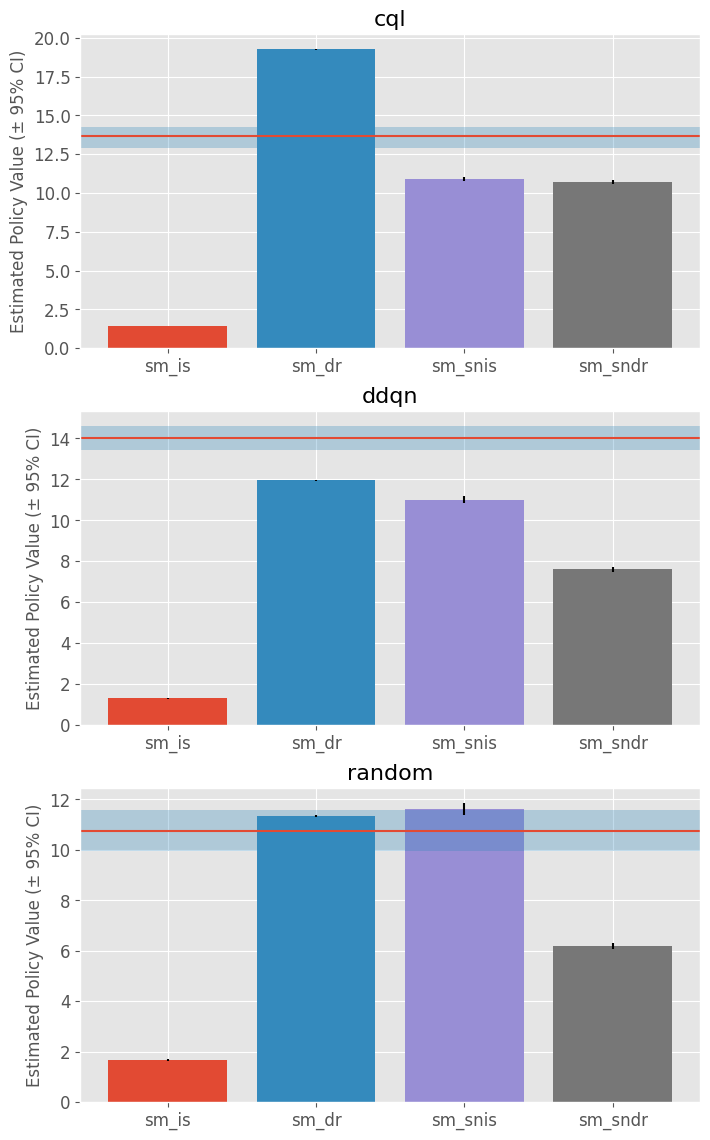

In [29]:
# opeの結果の比較・可視化
ope.visualize_off_policy_estimates(
    input_dict, 
    compared_estimators=state_marginal_estimators_name,
    random_state=random_state, 
    sharey=False,
)

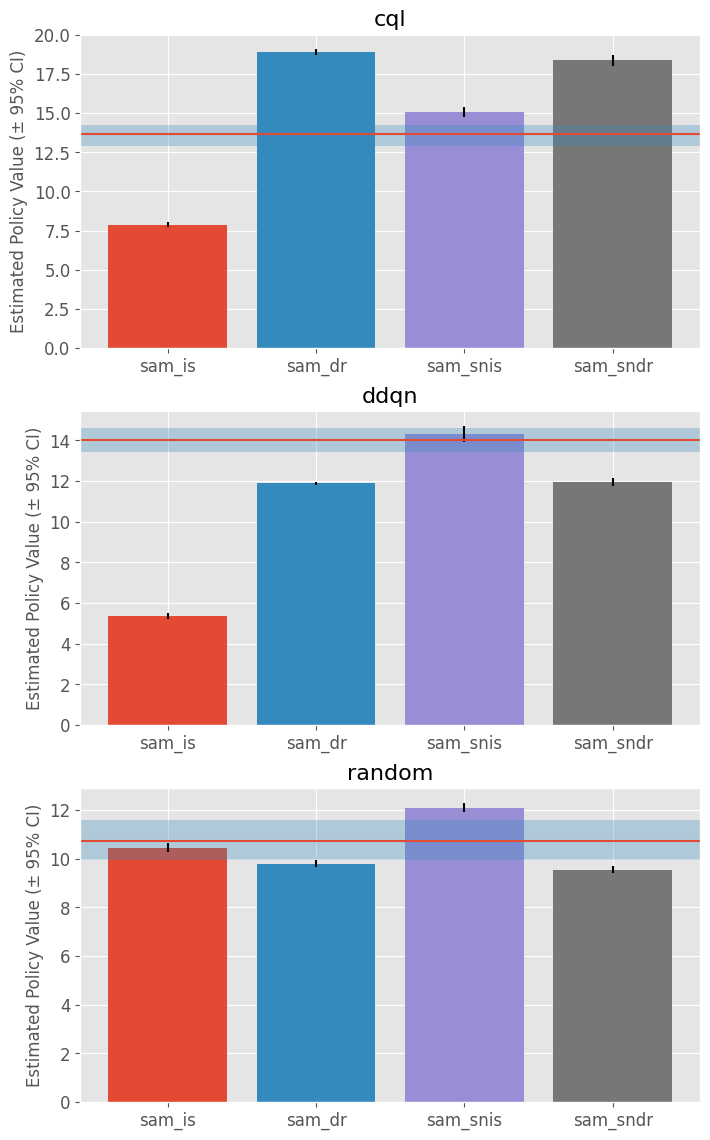

In [30]:
# opeの結果の比較・可視化
ope.visualize_off_policy_estimates(
    input_dict, 
    compared_estimators=state_action_marginal_estimators_name,
    random_state=random_state, 
    sharey=False,
)

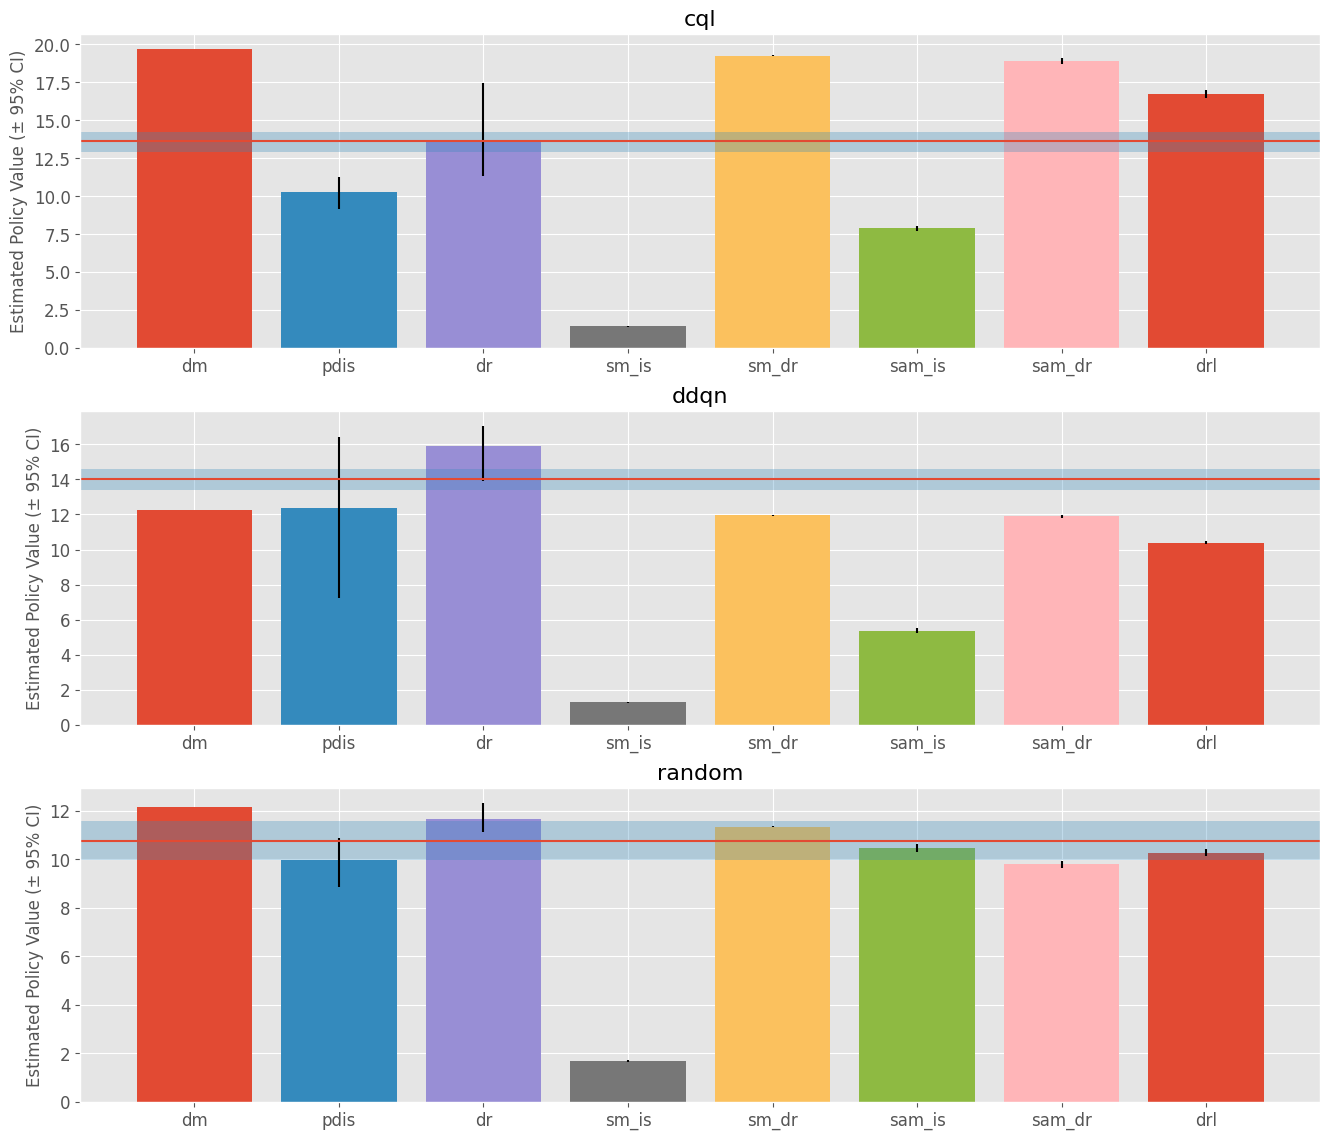

In [31]:
# opeの結果の比較・可視化
ope.visualize_off_policy_estimates(
    input_dict, 
    compared_estimators=["dm", "pdis", "dr", "sm_is", "sm_dr", "sam_is", "sam_dr", "drl"],
    random_state=random_state, 
    sharey=False,
)

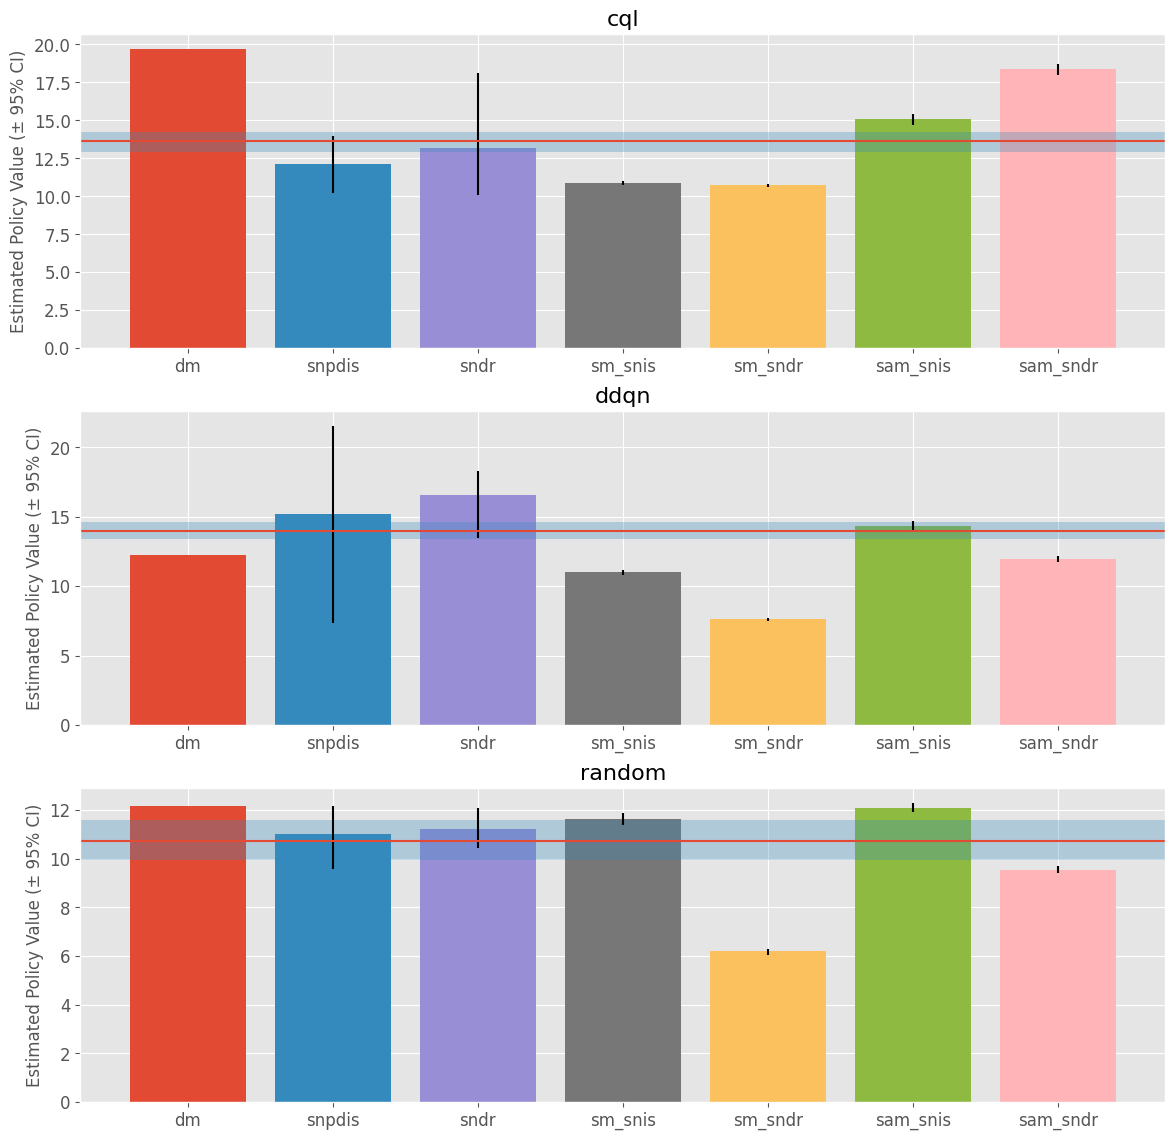

In [32]:
ope.visualize_off_policy_estimates(
    input_dict, 
    compared_estimators=["dm", "snpdis", "sndr", "sm_snis", "sm_sndr", "sam_snis", "sam_sndr"],
    random_state=random_state, 
    sharey=False,
)

OPEのより発展的なトピック(累積分布関数の推定など) やオフ方策選択 (OPS) は，以下を参照してください．[examples/quickstart_ja/rtb/rtb_synthetic_discrete_advanced_ja.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart_ja/rtb/rtb_synthetic_discrete_advanced_ja.ipynb). 

連続的な行動空間に対する例は，以下を参照してください． [examples/quickstart_ja/rtb/rtb_synthetic_continuous_zoo_ja.ipynb](https://github.com/hakuhodo-technologies/scope-rl/blob/main/examples/quickstart_ja/rtb/rtb_synthetic_continuous_zoo_ja.ipynb).

## 参考文献

- Yuta Saito, Shunsuke Aihara, Megumi Matsutani, and Yusuke Narita. \
"Open Bandit Dataset and Pipeline: Towards Realistic and Reproducible Off-Policy Evaluation.", 2021.

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- Christina J. Yuan, Yash Chandak, Stephen Giguere, Philip S. Thomas, and Scott Niekum. \
"SOPE: Spectrum of Off-Policy Estimators.", 2021.

- Nathan Kallus and Masatoshi Uehara. \
"Double Reinforcement Learning for Efficient Off-Policy Evaluation in Markov Decision Processes.", 2020.

- Masatoshi Uehara, Jiawei Huang, and Nan Jiang. \
"Minimax Weight and Q-Function Learning for Off-Policy Evaluation.", 2020.

- Mengjiao Yang, Ofir Nachum, Bo Dai, Lihong Li, and Dale Schuurmans. \
"Off-Policy Evaluation via the Regularized Lagrangian.", 2020.

- Sergey Levine, Aviral Kumar, George Tucker, and Justin Fu. \
"Offline Reinforcement Learning: Tutorial, Review, and Perspectives on Open Problems." 2020.

- Aviral Kumar, Aurick Zhou, George Tucker, and Sergey Levine. \
"Conservative Q-Learning for Offline Reinforcement Learning.", 2020.

- Nathan Kallus and Masatoshi Uehara. \
"Intrinsically Efficient, Stable, and Bounded Off-Policy Evaluation for Reinforcement Learning.", 2019.

- Hoang Le, Cameron Voloshin, and Yisong Yue. \
"Batch Policy Learning under Constraints.", 2019.

- Qiang Liu, Lihong Li, Ziyang Tang, and Dengyong Zhou. \
"Breaking the Curse of Horizon: Infinite-Horizon Off-Policy Estimation.", 2018

- Di Wu, Xiujun Chen, Xun Yang, Hao Wang, Qing Tan, Xiaoxun Zhang, Jian Xu, and Kun Gai. \
"Budget Constrained Bidding by Model-free Reinforcement Learning in Display Advertising.", 2018.

- Jun Zhao, Guang Qiu, Ziyu Guan, Wei Zhao, and Xiaofei He. \
"Deep Reinforcement Learning for Sponsored Search Real-time Bidding.", 2018.

- Josiah P. Hanna, Peter Stone, and Scott Niekum. \
"Bootstrapping with Models: Confidence Intervals for Off-Policy Evaluation.", 2017.

- Nan Jiang and Lihong Li. \
"Doubly Robust Off-policy Value Evaluation for Reinforcement Learning.", 2016.

- Philip S. Thomas and Emma Brunskill. \
"Data-Efficient Off-Policy Policy Evaluation for Reinforcement Learning.", 2016.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Policy Improvement.", 2015.

- Philip S. Thomas, Georgios Theocharous, and Mohammad Ghavamzadeh. \
"High Confidence Off-Policy Evaluation.", 2015.

- Adith Swaminathan and Thorsten Joachims. \
"The Self-Normalized Estimator for Counterfactual Learning.", 2015.

- Hado van Hasselt, Arthur Guez, and David Silver. \
"Deep Reinforcement Learning with Double Q-learning.", 2015.

- Miroslav Dudík, Dumitru Erhan, John Langford, and Lihong Li. \
"Doubly Robust Policy Evaluation and Optimization.", 2014.

- Alex Strehl, John Langford, Sham Kakade, and Lihong Li. \
"Learning from Logged Implicit Exploration Data.", 2010.

- Alina Beygelzimer and John Langford. \
"The Offset Tree for Learning with Partial Labels.", 2009.

- Doina Precup, Richard S. Sutton, and Satinder P. Singh. \
"Eligibility Traces for Off-Policy Policy Evaluation.", 2000.